# Fast Oriented Text Spotting inference notebook

In [1]:
# importing the libraries
import glob
import csv
import cv2
import time
import os
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import matplotlib.patches as Patches
from shapely.geometry import Polygon
import random
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import threading
import shutil
import pandas as pd
import os
import math
import csv
import cv2
import time
import shutil
import os
import numpy as np
import scipy.optimize
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.patches as Patches
from shapely.geometry import Polygon
import random
import tensorflow as tf
from tqdm import tqdm
import multiprocessing
import scipy.io as sio
try:
    import queue
except ImportError:
    import Queue as queue


In [ ]:
#The reference for below code is taken from 
#https://github.com/Pay20Y/FOTS_TF
#https://github.com/jiangxiluning/FOTS.PyTorch
#https://github.com/RaidasGrisk/tf2-fots

# loading the functions  for generating  bounding boxes around the text

In [2]:
#All the functions in this block are used to generating  bounding boxes around the text

# This Function is used to calculate AREA of polygon
def polygon_area(poly):
    '''
    compute area of a polygon
    '''
    edge = [
        (poly[1][0] - poly[0][0]) * (poly[1][1] + poly[0][1]),
        (poly[2][0] - poly[1][0]) * (poly[2][1] + poly[1][1]),
        (poly[3][0] - poly[2][0]) * (poly[3][1] + poly[2][1]),
        (poly[0][0] - poly[3][0]) * (poly[0][1] + poly[3][1])
    ]
    return np.sum(edge)/2.

# This function is used to discard invalid polygons and check direction of them

def check_and_validate_polys(polys, tags, xxx_todo_changeme):


    def is_polygon(poly):
        for i in range(3):
            p0 = poly[i]

        p1 = poly[(i + 1) % 4]
        p2 = poly[(i + 2) % 4]
    
        if p0[0] == p1[0] and p1[1] == p0[1]:
            return False
        if p0[0] == p2[0] and p2[1] == p0[1]:
            return False
        if p1[0] == p2[0] and p1[1] == p2[1]:
            return False
    
        if p0[0] == p1[0]:
            if p1[0] == p2[0]:
                return False
        else:
            if p1[0] != p2[0]:
                k1 = (p1[1] - p0[1]) / (p1[0] - p0[0])
                k2 = (p2[1] - p1[1]) / (p2[0] - p1[0])
                if abs(k1 - k2) < 1e-6:
                    return False
                else:
                    if p1[1] == p2[1]:
                        return False
        
        return True

    (h, w) = xxx_todo_changeme
    if polys.shape[0] == 0:
        return polys
    polys[:, :, 0] = np.clip(polys[:, :, 0], 0, w - 1)
    polys[:, :, 1] = np.clip(polys[:, :, 1], 0, h - 1)

    validated_polys = []
    validated_tags = []
    for poly, tag in zip(polys, tags):
        p_area = polygon_area(poly)

        # memory error after hitting not a polygon !!!
        if is_polygon(poly) is False:
            #print("not a polygon: ", poly)
            continue

        if abs(p_area) < 1:
            # print poly
            #print('invalid poly')
            continue
        if p_area > 0:
            #print('poly in wrong direction')
            poly = poly[(0, 3, 2, 1), :]
        validated_polys.append(poly)
        validated_tags.append(tag)
    return np.array(validated_polys), np.array(validated_tags)    
    
    
#This function is implementation of Polygon Shrinkage Algorithm 
def shrink_poly(poly, r):
    '''
    fit a poly inside the origin poly
    used for generate the score map
    '''
    # shrink ratio
    R = 0.3
    # find the longer pair
    if np.linalg.norm(poly[0] - poly[1]) + np.linalg.norm(poly[2] - poly[3]) > \
                    np.linalg.norm(poly[0] - poly[3]) + np.linalg.norm(poly[1] - poly[2]):
        # first move (p0, p1), (p2, p3), then (p0, p3), (p1, p2)
        ## p0, p1
        theta = np.arctan2((poly[1][1] - poly[0][1]), (poly[1][0] - poly[0][0]))
        poly[0][0] += R * r[0] * np.cos(theta)
        poly[0][1] += R * r[0] * np.sin(theta)
        poly[1][0] -= R * r[1] * np.cos(theta)
        poly[1][1] -= R * r[1] * np.sin(theta)
        ## p2, p3
        theta = np.arctan2((poly[2][1] - poly[3][1]), (poly[2][0] - poly[3][0]))
        poly[3][0] += R * r[3] * np.cos(theta)
        poly[3][1] += R * r[3] * np.sin(theta)
        poly[2][0] -= R * r[2] * np.cos(theta)
        poly[2][1] -= R * r[2] * np.sin(theta)
        ## p0, p3
        theta = np.arctan2((poly[3][0] - poly[0][0]), (poly[3][1] - poly[0][1]))
        poly[0][0] += R * r[0] * np.sin(theta)
        poly[0][1] += R * r[0] * np.cos(theta)
        poly[3][0] -= R * r[3] * np.sin(theta)
        poly[3][1] -= R * r[3] * np.cos(theta)
        ## p1, p2
        theta = np.arctan2((poly[2][0] - poly[1][0]), (poly[2][1] - poly[1][1]))
        poly[1][0] += R * r[1] * np.sin(theta)
        poly[1][1] += R * r[1] * np.cos(theta)
        poly[2][0] -= R * r[2] * np.sin(theta)
        poly[2][1] -= R * r[2] * np.cos(theta)
    else:
        ## p0, p3
        # print poly
        theta = np.arctan2((poly[3][0] - poly[0][0]), (poly[3][1] - poly[0][1]))
        poly[0][0] += R * r[0] * np.sin(theta)
        poly[0][1] += R * r[0] * np.cos(theta)
        poly[3][0] -= R * r[3] * np.sin(theta)
        poly[3][1] -= R * r[3] * np.cos(theta)
        ## p1, p2
        theta = np.arctan2((poly[2][0] - poly[1][0]), (poly[2][1] - poly[1][1]))
        poly[1][0] += R * r[1] * np.sin(theta)
        poly[1][1] += R * r[1] * np.cos(theta)
        poly[2][0] -= R * r[2] * np.sin(theta)
        poly[2][1] -= R * r[2] * np.cos(theta)
        ## p0, p1
        theta = np.arctan2((poly[1][1] - poly[0][1]), (poly[1][0] - poly[0][0]))
        poly[0][0] += R * r[0] * np.cos(theta)
        poly[0][1] += R * r[0] * np.sin(theta)
        poly[1][0] -= R * r[1] * np.cos(theta)
        poly[1][1] -= R * r[1] * np.sin(theta)
        ## p2, p3
        theta = np.arctan2((poly[2][1] - poly[3][1]), (poly[2][0] - poly[3][0]))
        poly[3][0] += R * r[3] * np.cos(theta)
        poly[3][1] += R * r[3] * np.sin(theta)
        poly[2][0] -= R * r[2] * np.cos(theta)
        poly[2][1] -= R * r[2] * np.sin(theta)
    return poly



#Compute distance between p1-p2 and p3
def point_dist_to_line(p1, p2, p3):
    '''compute the distance from p3 to p1-p2'''
    return np.linalg.norm(np.cross(p2 - p1, p1 - p3)) / np.linalg.norm(p2 - p1)

#Find equation of line using two 2D points p1 and p2
def fit_line(p1, p2):
    '''fit a line ax+by+c = 0'''
    if p1[0] == p1[1]:
        return [1., 0., -p1[0]]
    else:
        [k, b] = np.polyfit(p1, p2, deg=1)
        return [k, -1., b]

#Find Intersection poitn of 2 lines
def line_cross_point(line1, line2):
    '''line1 0= ax+by+c, compute the cross point of line1 and line2'''
    if line1[0] != 0 and line1[0] == line2[0]:
        print('Cross point does not exist')
        return None
    if line1[0] == 0 and line2[0] == 0:
        print('Cross point does not exist')
        return None
    if line1[1] == 0:
        x = -line1[2]
        y = line2[0] * x + line2[2]
    elif line2[1] == 0:
        x = -line2[2]
        y = line1[0] * x + line1[2]
    else:
        k1, _, b1 = line1
        k2, _, b2 = line2
        x = -(b1-b2)/(k1-k2)
        y = k1*x + b1
    return np.array([x, y], dtype=np.float32)

#Get Equation of line that is perpendicular to line passing through a point
def line_verticle(line, point):
    '''get the verticle line from line across point'''
    if line[1] == 0:
        verticle = [0, -1, point[1]]
    else:
        if line[0] == 0:
            verticle = [1, 0, -point[0]]
        else:
            verticle = [-1./line[0], -1, point[1] - (-1/line[0] * point[0])]
    return verticle

# Convert a parallelogram to rectangle
def rectangle_from_parallelogram(poly):
    '''
    fit a rectangle from a parallelogram
    '''
    p0, p1, p2, p3 = poly
    angle_p0 = np.arccos(np.dot(p1-p0, p3-p0)/(np.linalg.norm(p0-p1) * np.linalg.norm(p3-p0)))
    if angle_p0 < 0.5 * np.pi:
        if np.linalg.norm(p0 - p1) > np.linalg.norm(p0-p3):
            # p0 and p2
            ## p0
            p2p3 = fit_line([p2[0], p3[0]], [p2[1], p3[1]])
            p2p3_verticle = line_verticle(p2p3, p0)

            new_p3 = line_cross_point(p2p3, p2p3_verticle)
            ## p2
            p0p1 = fit_line([p0[0], p1[0]], [p0[1], p1[1]])
            p0p1_verticle = line_verticle(p0p1, p2)

            new_p1 = line_cross_point(p0p1, p0p1_verticle)
            return np.array([p0, new_p1, p2, new_p3], dtype=np.float32)
        else:
            p1p2 = fit_line([p1[0], p2[0]], [p1[1], p2[1]])
            p1p2_verticle = line_verticle(p1p2, p0)

            new_p1 = line_cross_point(p1p2, p1p2_verticle)
            p0p3 = fit_line([p0[0], p3[0]], [p0[1], p3[1]])
            p0p3_verticle = line_verticle(p0p3, p2)

            new_p3 = line_cross_point(p0p3, p0p3_verticle)
            return np.array([p0, new_p1, p2, new_p3], dtype=np.float32)
    else:
        if np.linalg.norm(p0-p1) > np.linalg.norm(p0-p3):
            # p1 and p3
            ## p1
            p2p3 = fit_line([p2[0], p3[0]], [p2[1], p3[1]])
            p2p3_verticle = line_verticle(p2p3, p1)

            new_p2 = line_cross_point(p2p3, p2p3_verticle)
            ## p3
            p0p1 = fit_line([p0[0], p1[0]], [p0[1], p1[1]])
            p0p1_verticle = line_verticle(p0p1, p3)

            new_p0 = line_cross_point(p0p1, p0p1_verticle)
            return np.array([new_p0, p1, new_p2, p3], dtype=np.float32)
        else:
            p0p3 = fit_line([p0[0], p3[0]], [p0[1], p3[1]])
            p0p3_verticle = line_verticle(p0p3, p1)

            new_p0 = line_cross_point(p0p3, p0p3_verticle)
            p1p2 = fit_line([p1[0], p2[0]], [p1[1], p2[1]])
            p1p2_verticle = line_verticle(p1p2, p3)

            new_p2 = line_cross_point(p1p2, p1p2_verticle)
            return np.array([new_p0, p1, new_p2, p3], dtype=np.float32)

#Sorting a rectangle to get all point in clockwies manner
def sort_rectangle(poly):
    '''sort the four coordinates of the polygon, points in poly should be sorted clockwise'''
    # First find the lowest point
    p_lowest = np.argmax(poly[:, 1])
    if np.count_nonzero(poly[:, 1] == poly[p_lowest, 1]) == 2:
        # if the bottom line is parallel to x-axis, then p0 must be the upper-left corner
        p0_index = np.argmin(np.sum(poly, axis=1))
        p1_index = (p0_index + 1) % 4
        p2_index = (p0_index + 2) % 4
        p3_index = (p0_index + 3) % 4
        return poly[[p0_index, p1_index, p2_index, p3_index]], 0.
    else:
        # find the point that sits right to the lowest point
        p_lowest_right = (p_lowest - 1) % 4
        p_lowest_left = (p_lowest + 1) % 4
        angle = np.arctan(-(poly[p_lowest][1] - poly[p_lowest_right][1])/(poly[p_lowest][0] - poly[p_lowest_right][0]))
        # assert angle > 0
        if angle <= 0:
            print(angle, poly[p_lowest], poly[p_lowest_right])
        if angle/np.pi * 180 > 45:
            #this point is p2
            p2_index = p_lowest
            p1_index = (p2_index - 1) % 4
            p0_index = (p2_index - 2) % 4
            p3_index = (p2_index + 1) % 4
            return poly[[p0_index, p1_index, p2_index, p3_index]], -(np.pi/2 - angle)
        else:
            # this point is p3
            p3_index = p_lowest
            p0_index = (p3_index + 1) % 4
            p1_index = (p3_index + 2) % 4
            p2_index = (p3_index + 3) % 4
            return poly[[p0_index, p1_index, p2_index, p3_index]], angle


def restore_rectangle_rbox(origin, geometry):
    ''' Resotre rectangle tbox'''
    d = geometry[:, :4]
    angle = geometry[:, 4]
    # for angle > 0
    origin_0 = origin[angle >= 0]
    d_0 = d[angle >= 0]
    angle_0 = angle[angle >= 0]
    if origin_0.shape[0] > 0:
        p = np.array([np.zeros(d_0.shape[0]), -d_0[:, 0] - d_0[:, 2],
                      d_0[:, 1] + d_0[:, 3], -d_0[:, 0] - d_0[:, 2],
                      d_0[:, 1] + d_0[:, 3], np.zeros(d_0.shape[0]),
                      np.zeros(d_0.shape[0]), np.zeros(d_0.shape[0]),
                      d_0[:, 3], -d_0[:, 2]])
        p = p.transpose((1, 0)).reshape((-1, 5, 2))  # N*5*2

        rotate_matrix_x = np.array([np.cos(angle_0), np.sin(angle_0)]).transpose((1, 0))
        rotate_matrix_x = np.repeat(rotate_matrix_x, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))  # N*5*2

        rotate_matrix_y = np.array([-np.sin(angle_0), np.cos(angle_0)]).transpose((1, 0))
        rotate_matrix_y = np.repeat(rotate_matrix_y, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))

        p_rotate_x = np.sum(rotate_matrix_x * p, axis=2)[:, :, np.newaxis]  # N*5*1
        p_rotate_y = np.sum(rotate_matrix_y * p, axis=2)[:, :, np.newaxis]  # N*5*1

        p_rotate = np.concatenate([p_rotate_x, p_rotate_y], axis=2)  # N*5*2

        p3_in_origin = origin_0 - p_rotate[:, 4, :]
        new_p0 = p_rotate[:, 0, :] + p3_in_origin  # N*2
        new_p1 = p_rotate[:, 1, :] + p3_in_origin
        new_p2 = p_rotate[:, 2, :] + p3_in_origin
        new_p3 = p_rotate[:, 3, :] + p3_in_origin

        new_p_0 = np.concatenate([new_p0[:, np.newaxis, :], new_p1[:, np.newaxis, :],
                                  new_p2[:, np.newaxis, :], new_p3[:, np.newaxis, :]], axis=1)  # N*4*2
    else:
        new_p_0 = np.zeros((0, 4, 2))
    # for angle < 0
    origin_1 = origin[angle < 0]
    d_1 = d[angle < 0]
    angle_1 = angle[angle < 0]
    if origin_1.shape[0] > 0:
        p = np.array([-d_1[:, 1] - d_1[:, 3], -d_1[:, 0] - d_1[:, 2],
                      np.zeros(d_1.shape[0]), -d_1[:, 0] - d_1[:, 2],
                      np.zeros(d_1.shape[0]), np.zeros(d_1.shape[0]),
                      -d_1[:, 1] - d_1[:, 3], np.zeros(d_1.shape[0]),
                      -d_1[:, 1], -d_1[:, 2]])
        p = p.transpose((1, 0)).reshape((-1, 5, 2))  # N*5*2

        rotate_matrix_x = np.array([np.cos(-angle_1), -np.sin(-angle_1)]).transpose((1, 0))
        rotate_matrix_x = np.repeat(rotate_matrix_x, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))  # N*5*2

        rotate_matrix_y = np.array([np.sin(-angle_1), np.cos(-angle_1)]).transpose((1, 0))
        rotate_matrix_y = np.repeat(rotate_matrix_y, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))

        p_rotate_x = np.sum(rotate_matrix_x * p, axis=2)[:, :, np.newaxis]  # N*5*1
        p_rotate_y = np.sum(rotate_matrix_y * p, axis=2)[:, :, np.newaxis]  # N*5*1

        p_rotate = np.concatenate([p_rotate_x, p_rotate_y], axis=2)  # N*5*2

        p3_in_origin = origin_1 - p_rotate[:, 4, :]
        new_p0 = p_rotate[:, 0, :] + p3_in_origin  # N*2
        new_p1 = p_rotate[:, 1, :] + p3_in_origin
        new_p2 = p_rotate[:, 2, :] + p3_in_origin
        new_p3 = p_rotate[:, 3, :] + p3_in_origin

        new_p_1 = np.concatenate([new_p0[:, np.newaxis, :], new_p1[:, np.newaxis, :],
                                  new_p2[:, np.newaxis, :], new_p3[:, np.newaxis, :]], axis=1)  # N*4*2
    else:
        new_p_1 = np.zeros((0, 4, 2))
    return np.concatenate([new_p_0, new_p_1])


#Some geometrical functions used in codes
def restore_rectangle(origin, geometry):
    return restore_rectangle_rbox(origin, geometry)

def getRotateRect(box):
    rect = cv2.minAreaRect(box)

    angle=rect[2]  # angle = [-90, 0)
    if angle < -45:
        rect = (rect[0], (rect[1][0], rect[1][1]), rect[2])
        angle += 90
        size = (rect[1][1],rect[1][0])
    else:
        rect = (rect[0], (rect[1][0], rect[1][1]), rect[2])
        size=rect[1]

    box_ = cv2.boxPoints(rect)
    return np.concatenate([rect[0], size]), angle, box_


#These Functions are used to Generate ROI params like out box,crop box & angles that we use to crop text from image
def generate_roiRotatePara(box, angle, expand_w = 60):
    '''Generate all ROI Parameterts'''
    p0_rect, p1_rect, p2_rect, p3_rect = box
    cxy = (p0_rect + p2_rect) / 2.
    size = np.array([np.linalg.norm(p0_rect - p1_rect), np.linalg.norm(p0_rect - p3_rect)])
    rrect = np.concatenate([cxy, size])

    box=np.array(box)

    points=np.array(box, dtype=np.int32)
    xmin=np.min(points[:,0])
    xmax=np.max(points[:,0])
    ymin=np.min(points[:,1])
    ymax=np.max(points[:,1])
    bbox = np.array([xmin, ymin, xmax, ymax])
    if np.any(bbox < -expand_w):
        return None
    
    rrect[:2] -= bbox[:2]
    rrect[:2] -= rrect[2:] / 2
    rrect[2:] += rrect[:2]

    bbox[2:] -= bbox[:2]

    rrect[::2] = np.clip(rrect[::2], 0, bbox[2])
    rrect[1::2] = np.clip(rrect[1::2], 0, bbox[3])
    rrect[2:] -= rrect[:2]
    
    return bbox.astype(np.int32), rrect.astype(np.int32), - angle

def restore_roiRotatePara(box):
    rectange, rotate_angle = sort_rectangle(box)
    return generate_roiRotatePara(rectange, rotate_angle)

#This function is used to generate geo_map,score_map, training_mask,corp_box,out_box,angle that we use while training model
def generate_rbox(im_size, polys, tags):
    '''Genrate score_map and geo_map for image'''
    h, w = im_size
    poly_mask = np.zeros((h, w), dtype=np.uint8)
    score_map = np.zeros((h, w), dtype=np.uint8)
    geo_map = np.zeros((h, w, 5), dtype=np.float32)

    outBoxs = []
    cropBoxs = []
    angles = []
    text_tags = []
    recg_masks = []
    # mask used during traning, to ignore some hard areas
    training_mask = np.ones((h, w), dtype=np.uint8)
    for poly_idx, poly_tag in enumerate(zip(polys, tags)):
        poly = poly_tag[0]
        #print(poly)
        tag = poly_tag[1]
        #print(tag)
        r = [None, None, None, None]
        for i in range(4):
            r[i] = min(np.linalg.norm(poly[i] - poly[(i + 1) % 4]),
                       np.linalg.norm(poly[i] - poly[(i - 1) % 4]))
        # score map
        shrinked_poly = shrink_poly(poly.copy(), r).astype(np.int32)[np.newaxis, :, :]
        cv2.fillPoly(score_map, shrinked_poly, 1)
        cv2.fillPoly(poly_mask, shrinked_poly, poly_idx + 1)

        # if geometry == 'RBOX':
        # generate a parallelogram for any combination of two vertices
        fitted_parallelograms = []
        for i in range(4):
            p0 = poly[i]
            p1 = poly[(i + 1) % 4]
            p2 = poly[(i + 2) % 4]
            p3 = poly[(i + 3) % 4]
            edge = fit_line([p0[0], p1[0]], [p0[1], p1[1]])
            backward_edge = fit_line([p0[0], p3[0]], [p0[1], p3[1]])
            forward_edge = fit_line([p1[0], p2[0]], [p1[1], p2[1]])
            if point_dist_to_line(p0, p1, p2) > point_dist_to_line(p0, p1, p3):
                #  parallel lines through p2
                if edge[1] == 0:
                    edge_opposite = [1, 0, -p2[0]]
                else:
                    edge_opposite = [edge[0], -1, p2[1] - edge[0] * p2[0]]
            else:
                # after p3
                if edge[1] == 0:
                    edge_opposite = [1, 0, -p3[0]]
                else:
                    edge_opposite = [edge[0], -1, p3[1] - edge[0] * p3[0]]
            # move forward edge
            new_p0 = p0
            new_p1 = p1
            new_p2 = p2
            new_p3 = p3
            new_p2 = line_cross_point(forward_edge, edge_opposite)
            if point_dist_to_line(p1, new_p2, p0) > point_dist_to_line(p1, new_p2, p3):
                # across p0
                if forward_edge[1] == 0:
                    forward_opposite = [1, 0, -p0[0]]
                else:
                    forward_opposite = [forward_edge[0], -1, p0[1] - forward_edge[0] * p0[0]]
            else:
                # across p3
                if forward_edge[1] == 0:
                    forward_opposite = [1, 0, -p3[0]]
                else:
                    forward_opposite = [forward_edge[0], -1, p3[1] - forward_edge[0] * p3[0]]
            new_p0 = line_cross_point(forward_opposite, edge)
            new_p3 = line_cross_point(forward_opposite, edge_opposite)
            fitted_parallelograms.append([new_p0, new_p1, new_p2, new_p3, new_p0])
            # or move backward edge
            new_p0 = p0
            new_p1 = p1
            new_p2 = p2
            new_p3 = p3
            new_p3 = line_cross_point(backward_edge, edge_opposite)
            if point_dist_to_line(p0, p3, p1) > point_dist_to_line(p0, p3, p2):
                # across p1
                if backward_edge[1] == 0:
                    backward_opposite = [1, 0, -p1[0]]
                else:
                    backward_opposite = [backward_edge[0], -1, p1[1] - backward_edge[0] * p1[0]]
            else:
                # across p2
                if backward_edge[1] == 0:
                    backward_opposite = [1, 0, -p2[0]]
                else:
                    backward_opposite = [backward_edge[0], -1, p2[1] - backward_edge[0] * p2[0]]
            new_p1 = line_cross_point(backward_opposite, edge)
            new_p2 = line_cross_point(backward_opposite, edge_opposite)
            fitted_parallelograms.append([new_p0, new_p1, new_p2, new_p3, new_p0])
        areas = [Polygon(t).area for t in fitted_parallelograms]
        parallelogram = np.array(fitted_parallelograms[np.argmin(areas)][:-1], dtype=np.float32)
        # sort thie polygon
        parallelogram_coord_sum = np.sum(parallelogram, axis=1)
        min_coord_idx = np.argmin(parallelogram_coord_sum)
        parallelogram = parallelogram[
            [min_coord_idx, (min_coord_idx + 1) % 4, (min_coord_idx + 2) % 4, (min_coord_idx + 3) % 4]]

        rectange = rectangle_from_parallelogram(parallelogram)
        rectange, rotate_angle = sort_rectangle(rectange)

        p0_rect, p1_rect, p2_rect, p3_rect = rectange

        # if the poly is too small, then ignore it during training
        poly_h = min(np.linalg.norm(p0_rect - p3_rect), np.linalg.norm(p1_rect - p2_rect))
        poly_w = min(np.linalg.norm(p0_rect - p1_rect), np.linalg.norm(p2_rect - p3_rect))

        invaild = (min(poly_h, poly_w) < 6) or tag is None or (True and poly_h > poly_w * 2)

        if invaild:
            cv2.fillPoly(training_mask, poly.astype(np.int32)[np.newaxis, :, :], 0)
        xy_in_poly = np.argwhere(poly_mask == (poly_idx + 1))
        
        if not invaild:
            roiRotatePara = generate_roiRotatePara(rectange, rotate_angle)
            if roiRotatePara:
                outBox, cropBox, angle = roiRotatePara
                if min(cropBox[2:]) > 6:
                    w , h = cropBox[2:]
                    textImgW = np.ceil(min(w / float(h) * 32, 256) / 4 /1)
                    #print(tag)
                    if textImgW >= 2 * min(len(tag), 16):  # avoid CTC error
                        outBoxs.append(outBox)
                        cropBoxs.append(cropBox)
                        angles.append(angle)
                        text_tags.append(tag[:16])
                        recg_masks.append(1.)

        for y, x in xy_in_poly:
            point = np.array([x, y], dtype=np.float32)
            # top
            geo_map[y, x, 0] = point_dist_to_line(p0_rect, p1_rect, point) + 3
            # right
            geo_map[y, x, 1] = point_dist_to_line(p1_rect, p2_rect, point) + 3
            # down
            geo_map[y, x, 2] = point_dist_to_line(p2_rect, p3_rect, point) + 3
            # left
            geo_map[y, x, 3] = point_dist_to_line(p3_rect, p0_rect, point) + 3
            # angle
            geo_map[y, x, 4] = rotate_angle
    if len(outBoxs) == 0:
        outBoxs.append([0, 0, 2 * 4, 2 * 4]) # keep extract From sharedConv feature map not zero
        cropBoxs.append([0, 0, 2 * 4, 2 * 4])
        angles.append(0.)
        text_tags.append([NUM_CLASSES - 2])
        recg_masks.append(0.)

    outBoxs = np.array(outBoxs, np.int32)
    cropBoxs = np.array(cropBoxs, np.int32)
    angles = np.array(angles, np.float32)

    return score_map, geo_map, training_mask, (outBoxs, cropBoxs, angles), text_tags, recg_masks
    

# Creating the detection architecture and loading the saved model weights

In [3]:
# Creating a deconv layer which used in text detection branch
class Deconv(tf.keras.layers.Layer):
    def __init__(self,name="deconv"):
        super().__init__(name)
        self.inp_size=0
        self.conv=None
        self.upsample=None
        self.bn=None
    def build(self,imshape):
        self.inp_size=imshape
        self.bn=tf.keras.layers.BatchNormalization()
        self.conv=tf.keras.layers.Conv2D(filters=self.inp_size[-1]//2,kernel_size=3,padding='same',activation='relu',kernel_initializer=tf.keras.initializers.GlorotNormal(seed=12),use_bias=False)
        self.upsample=tf.keras.layers.UpSampling2D(size=(2,2),interpolation='bilinear',data_format='channels_last',)
    def call(self,X):
    
        x1=self.upsample(X)
        x1=self.conv(x1)
        x1=self.bn(x1)
        x1=tf.keras.activations.relu(x1)
        return x1


# Preparing Text Detection Model
# we have used RESNET50 pretrained on imagenet dataset for Shared Convolutions
resnet=tf.keras.applications.ResNet50(input_shape=(512,512,3),include_top=False,weights='imagenet')
tf.keras.backend.clear_session()
layers=resnet.layers
x1,x2,x3,x4=None,None,None,None
for i in range(len(layers)): 
    x=layers[i]
    if x.name=='pool1_pool':
        x1=x
    if x.name=='conv3_block1_1_conv':
        x2=x
    if x.name=='conv4_block1_1_conv':
        x3=x   
    if x.name=='conv5_block3_2_conv':
        x4=x  
  #  input_1 ,conv1_relu
d=x4.output
d=Deconv('deconv1')(d)
d=tf.keras.layers.add([d,x3.output])

d=Deconv('deconv2')(d)
d=tf.keras.layers.add([d,x2.output])

d=Deconv('deconv3')(d)
d=tf.keras.layers.add([d,x1.output])
d=tf.keras.layers.BatchNormalization()(d)
d=Deconv('deconv4')(d)
d=Deconv('deconv5')(d)
score=tf.keras.layers.Conv2D(1,kernel_size=3,padding='same',activation='sigmoid')(d)

# Used this beacause sigmoid gives values in range of 0-1(as mentioned in git repository)
geo_map=tf.keras.layers.Conv2D(4,kernel_size=3,padding='same',activation='sigmoid')(d)*512
# Angles are assumed to be between [-45 to 45]
angle_map=(tf.keras.layers.Conv2D(1,kernel_size=3,padding='same',activation='sigmoid')(d)-0.5)*np.pi/2
out=tf.concat([score,geo_map,angle_map],axis=3)
detector=tf.keras.Model(resnet.input,out,name='detector')

for layers in resnet.layers:
     layers.trainable=False  

#Loading the saved weights of detection model
detector.load_weights('/content/drive/MyDrive/My /detector_icdar50.h5')

94773248/94765736 [==============================] - 1s 0us/step


# Creating the Recognition architecture and loading the saved model weights

In [4]:
#Text Recognition Model
inputs = tf.keras.layers.Input(name='the_input', shape=(64,128,3), dtype='float32')  

inner = tf.keras.layers.Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(inputs) 
inner = tf.keras.layers.BatchNormalization()(inner)
inner = tf.keras.layers.Activation('relu')(inner)
inner = tf.keras.layers.MaxPooling2D(pool_size=(2, 1), name='max1')(inner)

#inner = tf.keras.layers.Dropout(0.2)(inner)

inner = tf.keras.layers.Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)  
inner = tf.keras.layers.BatchNormalization()(inner)
inner = tf.keras.layers.Activation('relu')(inner)
inner = tf.keras.layers.MaxPooling2D(pool_size=(2, 1), name='max2')(inner)

#inner = tf.keras.layers.Dropout(0.2)(inner)

inner = tf.keras.layers.Conv2D(32, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)  
inner = tf.keras.layers.BatchNormalization()(inner)
inner = tf.keras.layers.Activation('relu')(inner)
inner = tf.keras.layers.Conv2D(32, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(inner)  
inner = tf.keras.layers.BatchNormalization()(inner)
inner = tf.keras.layers.Activation('relu')(inner)
inner = tf.keras.layers.MaxPooling2D(pool_size=(2, 1), name='max3')(inner)  

#inner = tf.keras.layers.Dropout(0.2)(inner)

inner = tf.keras.layers.Conv2D(32, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(inner)  
inner = tf.keras.layers.BatchNormalization()(inner)
inner = tf.keras.layers.Activation('relu')(inner)
inner = tf.keras.layers.Conv2D(32, (3, 3), padding='same', name='conv6')(inner)   
inner = tf.keras.layers.BatchNormalization()(inner)
inner = tf.keras.layers.Activation('relu')(inner)
inner = tf.keras.layers.MaxPooling2D(pool_size=(2, 1), name='max4')(inner)  

#inner = tf.keras.layers.Dropout(0.2)(inner)

inner = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', name='con7')(inner) 
inner = tf.keras.layers.BatchNormalization()(inner)
inner = tf.keras.layers.Activation('relu')(inner)
inner = tf.keras.layers.Reshape(target_shape=((64,512)), name='reshape')(inner)  
inner = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner) 

out=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32,return_sequences=True,go_backwards=True))(inner)
out=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128,return_sequences=True,go_backwards=True))(out)
x=tf.keras.layers.Dense(100)(out)#Here we hve given 100 because vocab size is 99 and 1 extra is for blank symbol
x=tf.keras.activations.softmax(x)
recognizer=tf.keras.models.Model(inputs,x)

# Save the weights
recognizer.load_weights('/content/drive/MyDrive/text_boxes/recoginzer1.h5')

# Building the final pipeline for inferences

In [5]:
#These Are Function that will be used while converting geo_maps to score_maps and returns bounding boxes for image after nms

def sort_poly(p):
  min_axis = np.argmin(np.sum(p, axis=1))
  p = p[[min_axis, (min_axis+1)%4, (min_axis+2)%4, (min_axis+3)%4]]
  if abs(p[0, 0] - p[1, 0]) > abs(p[0, 1] - p[1, 1]):
    return p
  else:
    return p[[0, 3, 2, 1]]
def intersection(g, p):
    g = Polygon(g[:8].reshape((4, 2)))
    p = Polygon(p[:8].reshape((4, 2)))
    if not g.is_valid or not p.is_valid:
        return 0
    inter = Polygon(g).intersection(Polygon(p)).area
    union = g.area + p.area - inter
    if union == 0:
        return 0
    else:
        return inter/union


def weighted_merge(g, p):
    g[:8] = (g[8] * g[:8] + p[8] * p[:8])/(g[8] + p[8])
    g[8] = (g[8] + p[8])
    return g


def standard_nms(S, thres):
    order = np.argsort(S[:, 8])[::-1]
    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        ovr = np.array([intersection(S[i], S[t]) for t in order[1:]])

        inds = np.where(ovr <= thres)[0]
        order = order[inds+1]

    return S[keep]


def nms_locality(polys, thres=0.3):
    '''
    :param polys: a N*9 numpy array. first 8 coordinates, then prob
    :return: boxes after nms
    '''
    S = []
    p = None
  
    for g in polys:
        if p is not None and intersection(g, p) > thres:
        
            p = weighted_merge(g, p)
        else:
            if p is not None:
                S.append(p)
            p = g
  
    if p is not None:
        S.append(p)

    if len(S) == 0:
        return np.array([])
    
    return standard_nms(np.array(S), thres)

In [6]:
#Preparing vocabulary for Text Recognition Branch
CHAR_VECTOR = " 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZÉ´-~`<>'.:;^/|!?$%#@&*()[]{}_+=,\\\""
NUM_CLASSES = len(CHAR_VECTOR) 
char_index={}
index_char={}
for i,val in enumerate(CHAR_VECTOR):
  index_char[i+1]=val
  char_index[val]=i+1

In [7]:
#This is final Inference function used for complete FOTS pipeline
def Pipeline(img):
  '''This function is main complete pipeline of our Model'''
  start_time=time.time()
  
  #1.Text Detection
  img=cv2.resize(img,(512,512))
  ii=detector.predict(np.expand_dims(img,axis=0))
  score_map=ii[0][:,:,0]
  geo_map=ii[0][:,:,1:]
  for ind in [0,1,2,3,4]:
    geo_map[:,:,ind]*=score_map

  #2.ROI Rotate  
  score_map_thresh=0.5
  box_thresh=0.1 
  nms_thres=0.2
  if len(score_map.shape) == 4:
    score_map = score_map[0, :, :, 0]
    geo_map = geo_map[0, :, :, :]

  # filter the score map
  xy_text = np.argwhere(score_map > score_map_thresh)

  # sort the text boxes via the y axis
  xy_text = xy_text[np.argsort(xy_text[:, 0])]

  # restore
  text_box_restored = restore_rectangle(xy_text[:, ::-1], geo_map[xy_text[:, 0], xy_text[:, 1], :]) # N*4*2
  boxes = np.zeros((text_box_restored.shape[0], 9), dtype=np.float32)
  boxes[:, :8] = text_box_restored.reshape((-1, 8))
  boxes[:, 8] = score_map[xy_text[:, 0], xy_text[:, 1]]
  boxes = nms_locality(boxes.astype(np.float64), nms_thres)
  

  # here we filter some low score boxes by the average score map, this is different from the orginal paper
  for i, box in enumerate(boxes):
    mask = np.zeros_like(score_map, dtype=np.uint8)
    cv2.fillPoly(mask, box[:8].reshape((-1, 4, 2)).astype(np.int32), 1)
    boxes[i, 8] = cv2.mean(score_map, mask)[0]
    if i==4:
      break
  if len(boxes)>0:
    boxes = boxes[boxes[:, 8] > box_thresh]
  boxes[:,:8:2] = np.clip(boxes[:,:8:2], 0, 512 - 1)
  boxes[:,1:8:2] = np.clip(boxes[:,1:8:2], 0, 512 - 1)  
  res = []
  result = []
  if len(boxes)>0:
    for box in boxes:
      box_ =  box[:8].reshape((4, 2))
      if np.linalg.norm(box_[0] - box_[1]) < 8 or np.linalg.norm(box_[3]-box_[0]) < 8:
        continue
      result.append(box_)
  res.append(np.array(result, np.float32))   

  box_index = []
  brotateParas = []
  filter_bsharedFeatures = []
  for i in range(len(res)):
    rotateParas = []
    rboxes=res[i]
    txt=[]
    for j, rbox in enumerate(rboxes):
      para = restore_roiRotatePara(rbox)
      if para and min(para[1][2:]) > 8:
        rotateParas.append(para)
        box_index.append((i, j))
    pts=[]   
    
    
    #3. Text Recognition (From boxes given by Text Detection+ROI Rotate) 
    if len(rotateParas) > 0:
      for num in range(len(rotateParas)):
        text=""
        out=rotateParas[num][0]
        crop=rotateParas[num][1]
        points=np.array([[out[0],out[1]],[out[0]+out[2],out[1]],[out[0]+out[2],out[1]+out[3]],[out[0],out[1]+out[3]]])
        angle=rotateParas[num][2] 
        img1=tf.image.crop_to_bounding_box(img,out[1],out[0],out[3],out[2])
        img2=tf.keras.preprocessing.image.random_rotation(img1,angle)
        img2=tf.image.crop_to_bounding_box(img2,crop[1],crop[0],crop[3],crop[2]).numpy()
        img2=cv2.resize(img2,(128,64))
        img2=cv2.detailEnhance(img2)
        ii=recognizer.predict(np.expand_dims(img2,axis=0))
        arr=tf.keras.backend.ctc_decode(ii,np.ones((1),'int8')*64,)
        for val in arr[0][0].numpy()[0]:
          if val==-1:
            break
          else:
            text+=index_char[val]
        txt.append(text)
        pts.append(points)
    
    # 4. Labeling detected and Recognized Text in Image  
    for i in range(len(txt)):
      cv2.polylines(img,[pts[i]],isClosed=True,color=(0,255,0),thickness=1)
      cv2.putText(img,txt[i],(pts[i][0][0],pts[i][0][1]),cv2.FONT_HERSHEY_SIMPLEX,1, (200,50,0), 2)
    end_time=time.time()
    print("Time Taken By Pipeline="+str(end_time-start_time)+" seconds")  
    return img,txt    


# Visualizing the results

In [8]:
def show_image(path):
    img=cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    im,txt=Pipeline(img)
    ax=plt.figure(figsize=(8,8))
    plt.title(','.join(txt),fontsize=20)
    plt.imshow(im)

Time Taken By Pipeline=1.3526318073272705 seconds
Time Taken By Pipeline=2.0098114013671875 seconds
Time Taken By Pipeline=1.5702400207519531 seconds
Time Taken By Pipeline=1.5986237525939941 seconds
Time Taken By Pipeline=1.1447525024414062 seconds


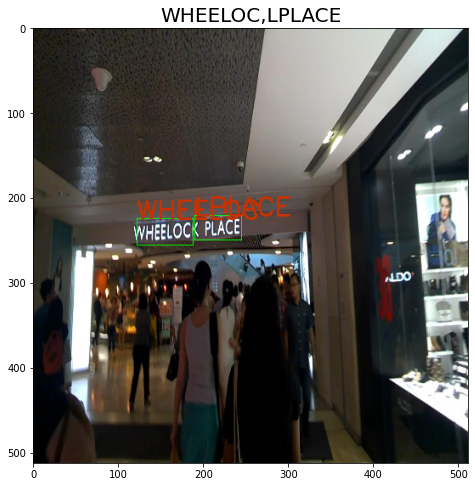

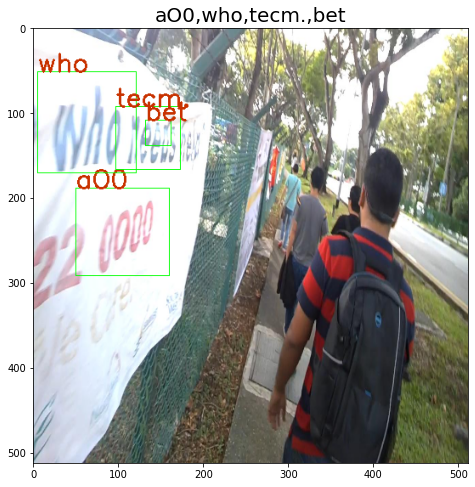

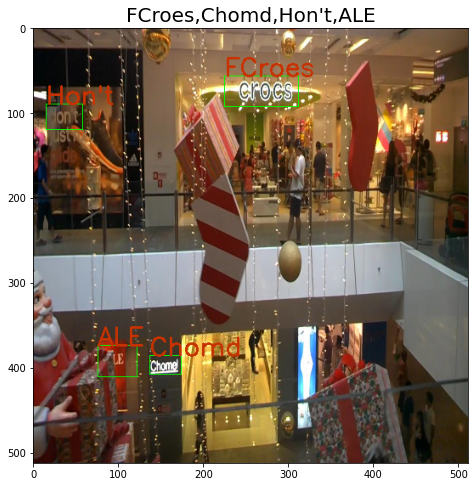

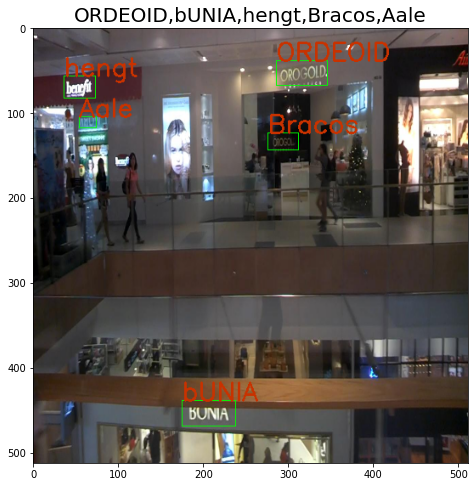

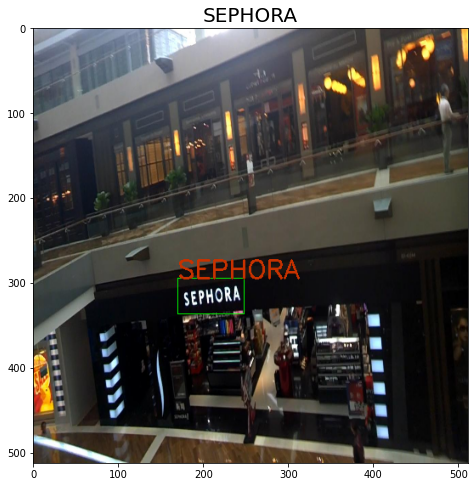

In [19]:
path=os.listdir('icdar')
img_path=['/content/icdar/'+i for i in path]
for i in img_path:
  show_image(i)

# Conclusion

1. As From above we can see that our detection model is doing average job but recognition model is not performing that good.
2. This is because We have only taken only 10k images from 800k images form synthtext and  have not trained our  models on the whole data of synthtext which is too large about 41GB because of less computation power and resources.
3. Both detection and recognition models can be trained on more data to provide with better results


# Future Work 

1. Will be making use of full synthtext data for training both the parts of detection and recgnition
2. Working on detection part to produce more accurate bounding boxes
3. Organizing the code in more readable form
